In [28]:
#coding=utf-8
import numpy as np
import pandas as pd
import random
import time
import json
import sys
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
# machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, roc_auc_score
from collections import Counter
from sklearn.model_selection import GroupKFold
import xgboost
import lightgbm as lgb

In [46]:
def get_weight_label(df_train, df_test):
    print '\nget_weight_label', '-' * 100
    print 'dt, fault_time isna : ', df_train['dt'].isna().sum(), df_train['fault_time'].isna().sum()
    # print df_train[['dt', 'fault_time']].head(100)
    df_train['dt'] = df_train['dt'].fillna('19970102')
    # df_train['dt'] = df_train['dt'].apply(lambda x: time.strftime('%Y-%m-%d', time.strptime(str(x), '%Y%m%d')))
    df_train['fault_time'] = df_train['fault_time'].fillna('1997-01-02')
    df_train['dt_day'] = df_train['dt'].apply(lambda x: int(time.mktime(time.strptime(str(x), "%Y-%m-%d")) / 24 / 3600))
    df_train['broken_day'] = df_train['fault_time'].apply(lambda x: int(time.mktime(time.strptime(x, "%Y-%m-%d")) / 24 / 3600))
    df_train['dis_day'] = (df_train['broken_day'] - df_train['dt_day']).apply(lambda x: -1 if x < 0 else -1 if x >= 30 else x)
    # print df_train[df_train['dt'] == 20170709][['dt', 'fault_time', 'broken_day', 'dt_day', 'dis_day']].head(10)
    df_train['label'] = df_train['dis_day'].apply(lambda x: 1 if x != -1 else 0)
    weight = df_train['dis_day'].apply(lambda x: 1 if x == -1 else 30 - x)
    label = df_train['label']
    # write_data_csv('df_train', df_train)
    # write_data_csv('df_test', df_test)
    return df_train, df_test, weight, label

In [12]:
df_train, df_test = read_data(-1)

201707 (129701, 516)
201708 (372119, 516)
201709 (595045, 516)
201710 (826694, 516)
201711 (1044560, 516)
201712 (1282160, 516)
201801 (1521179, 516)
201802 (1705737, 516)
201803 (1877623, 516)
201804 (2013209, 516)
201805 (2120657, 516)
201806 (2192399, 516)
201807 (2221725, 516)


In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2221725 entries, 0 to 29325
Columns: 516 entries, Unnamed: 0 to fault_time
dtypes: float64(510), int64(3), object(3)
memory usage: 8.6+ GB


In [17]:
temp = df_train.isna()
type(temp)
temp.shape

(2221725, 516)

In [19]:
temp = temp.sum()
type(temp)

pandas.core.series.Series

In [23]:
ratio = temp / len(df_train)
type(ratio)

pandas.core.series.Series

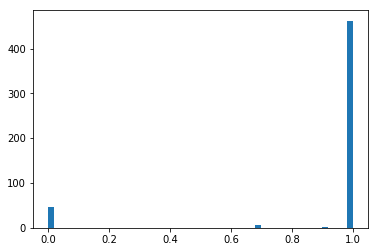

In [31]:
plt.hist(x = ratio.tolist(), bins = 50)
plt.show()

In [32]:
x = ratio > 0.5
print type(x)
print x.head(5)

<class 'pandas.core.series.Series'>
Unnamed: 0            False
serial_number         False
manufacturer          False
model                 False
smart_1_normalized    False
dtype: bool


In [35]:
print (ratio < 0.05).sum()
print (ratio < 0.1).sum()
print (ratio < 0.2).sum()
print (ratio < 0.3).sum()

47
47
47
47


In [37]:
print ratio[(ratio < 0.1) == True]

Unnamed: 0              0.000000
serial_number           0.000000
manufacturer            0.000000
model                   0.000000
smart_1_normalized      0.000072
smart_1raw              0.000072
smart_3_normalized      0.000070
smart_3raw              0.000070
smart_4_normalized      0.000070
smart_4raw              0.000070
smart_5_normalized      0.000070
smart_5raw              0.000070
smart_7_normalized      0.000070
smart_7raw              0.000070
smart_9_normalized      0.000071
smart_9raw              0.000071
smart_10_normalized     0.000073
smart_10raw             0.000073
smart_12_normalized     0.000077
smart_12raw             0.000077
smart_184_normalized    0.000078
smart_184raw            0.000078
smart_187_normalized    0.000079
smart_187raw            0.000079
smart_188_normalized    0.000080
smart_188raw            0.000080
smart_189_normalized    0.000076
smart_189raw            0.000076
smart_190_normalized    0.000072
smart_190raw            0.000072
smart_191_

In [47]:
df_train, df_test, weight, label = get_weight_label(df_train, df_test)


get_weight_label ----------------------------------------------------------------------------------------------------
dt, fault_time isna :  0 0


In [48]:
cols = ratio[ratio < 0.1].index
print type(cols), len(cols)

<class 'pandas.core.indexes.base.Index'> 47


In [49]:
cols = cols.tolist()
print cols

['Unnamed: 0', 'serial_number', 'manufacturer', 'model', 'smart_1_normalized', 'smart_1raw', 'smart_3_normalized', 'smart_3raw', 'smart_4_normalized', 'smart_4raw', 'smart_5_normalized', 'smart_5raw', 'smart_7_normalized', 'smart_7raw', 'smart_9_normalized', 'smart_9raw', 'smart_10_normalized', 'smart_10raw', 'smart_12_normalized', 'smart_12raw', 'smart_184_normalized', 'smart_184raw', 'smart_187_normalized', 'smart_187raw', 'smart_188_normalized', 'smart_188raw', 'smart_189_normalized', 'smart_189raw', 'smart_190_normalized', 'smart_190raw', 'smart_191_normalized', 'smart_191raw', 'smart_192_normalized', 'smart_192raw', 'smart_193_normalized', 'smart_193raw', 'smart_194_normalized', 'smart_194raw', 'smart_195_normalized', 'smart_195raw', 'smart_197_normalized', 'smart_197raw', 'smart_198_normalized', 'smart_198raw', 'smart_199_normalized', 'smart_199raw', 'dt']


In [50]:
print df_train['Unnamed: 0'].unique()

[    67    429    617 ... 471196 469476 458938]


In [53]:
features = [x for x in cols if x[-5 : ] == 'lized']

In [54]:
print features

['smart_1_normalized', 'smart_3_normalized', 'smart_4_normalized', 'smart_5_normalized', 'smart_7_normalized', 'smart_9_normalized', 'smart_10_normalized', 'smart_12_normalized', 'smart_184_normalized', 'smart_187_normalized', 'smart_188_normalized', 'smart_189_normalized', 'smart_190_normalized', 'smart_191_normalized', 'smart_192_normalized', 'smart_193_normalized', 'smart_194_normalized', 'smart_195_normalized', 'smart_197_normalized', 'smart_198_normalized', 'smart_199_normalized']


In [55]:
print len(features)

21


C:\file\anaconda2\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


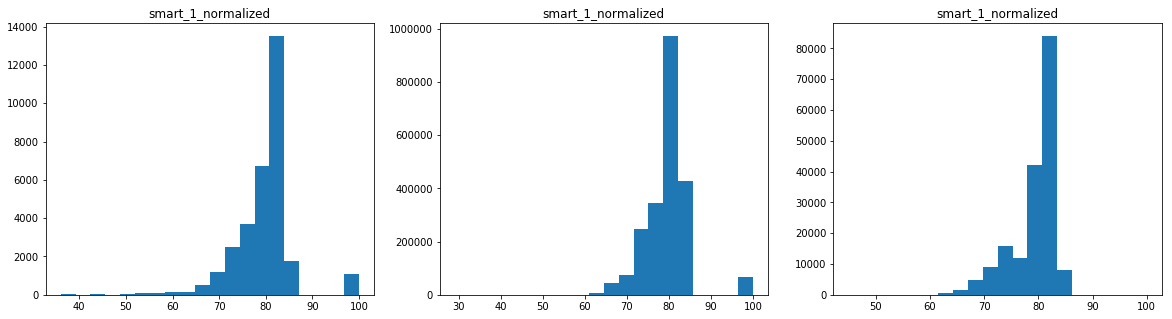

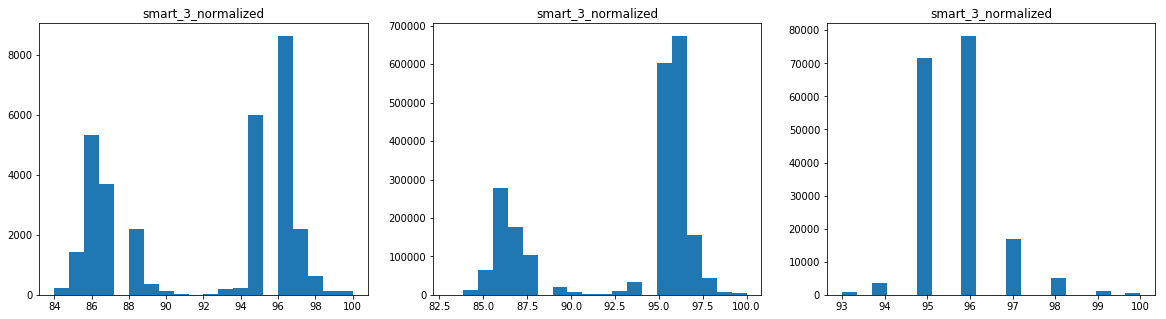

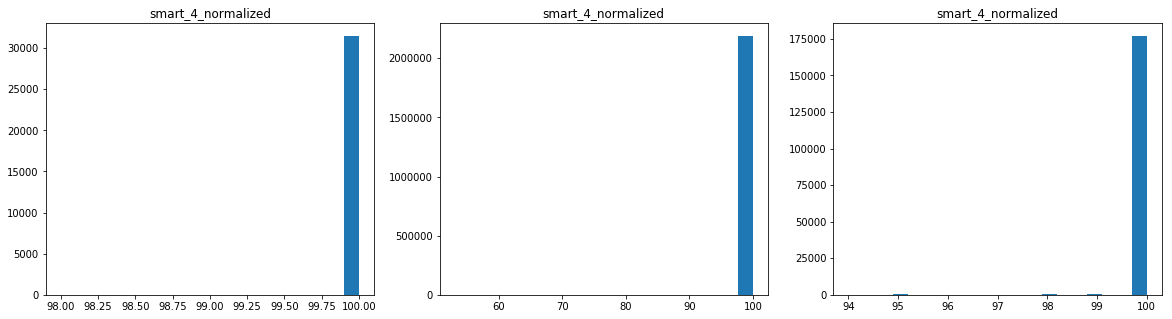

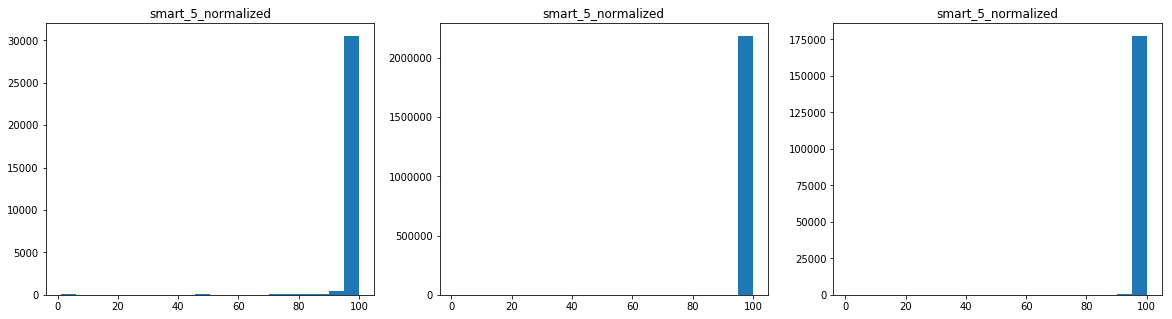

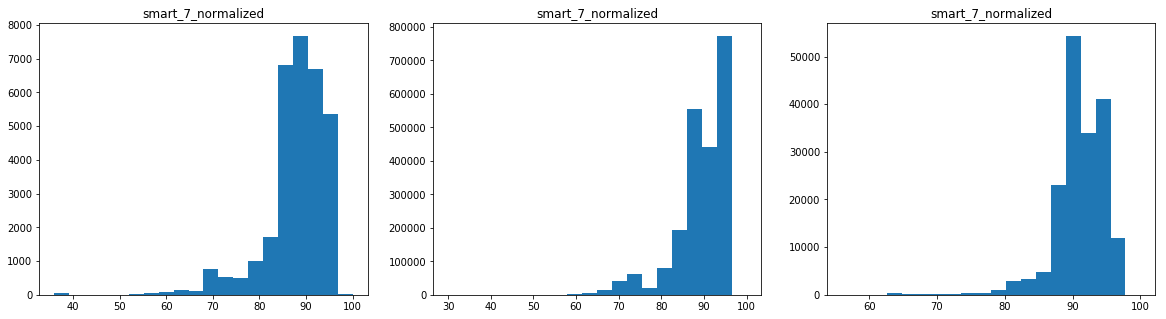

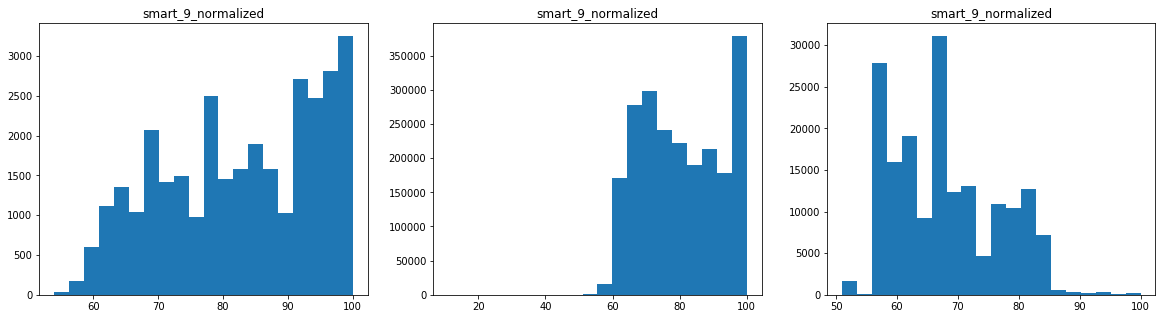

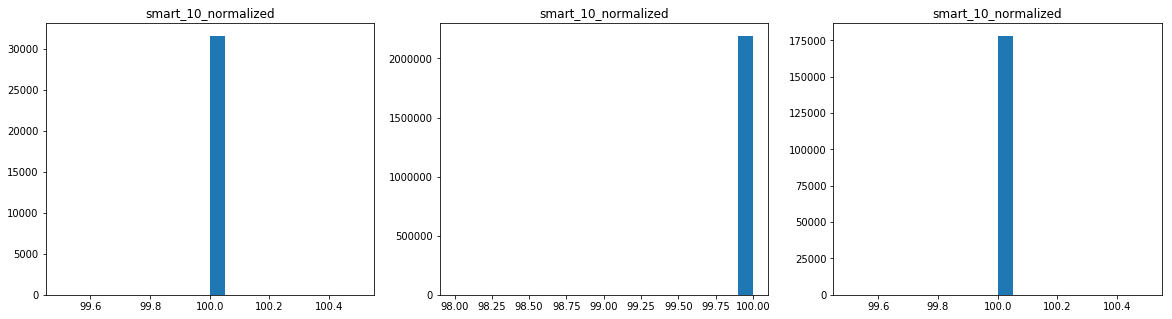

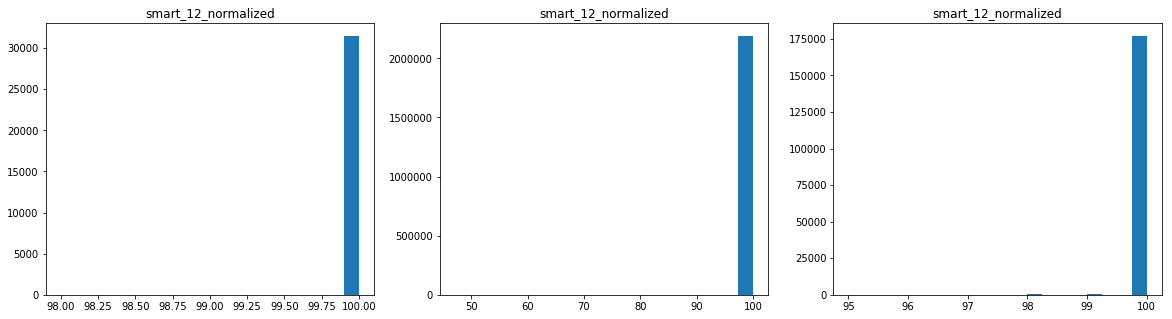

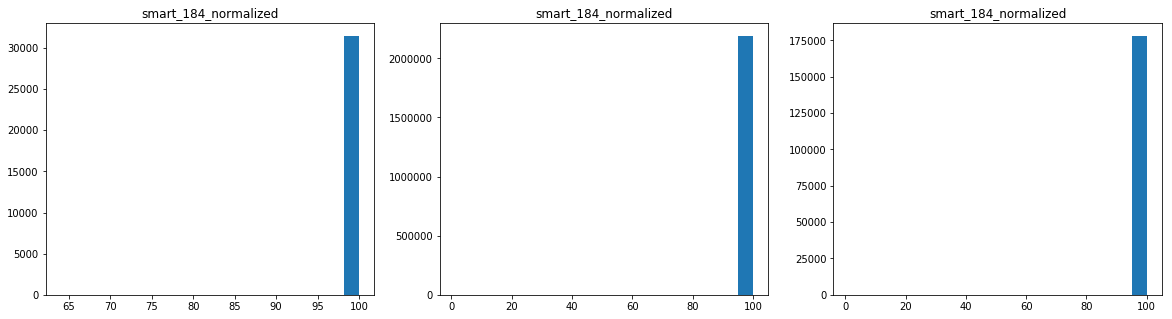

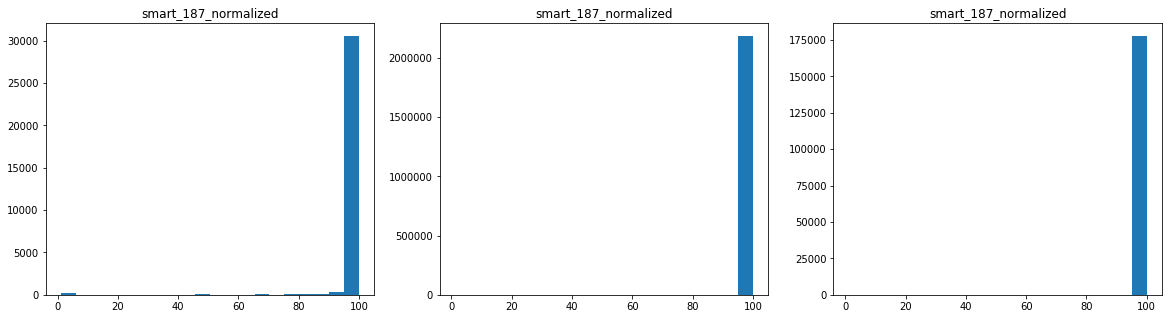

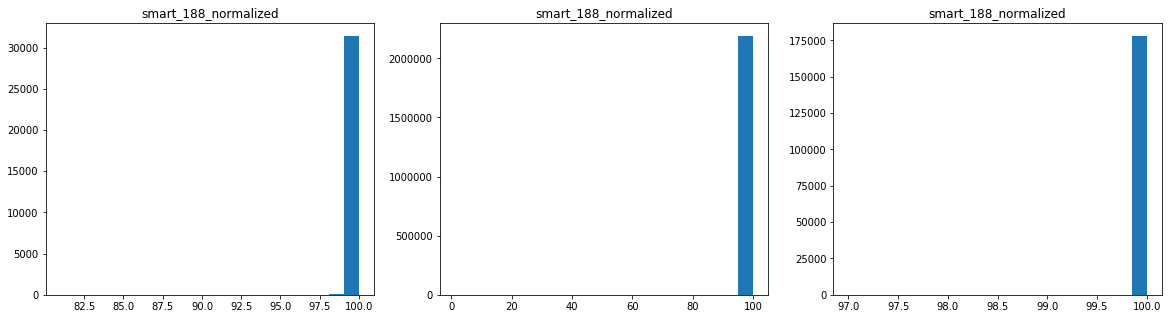

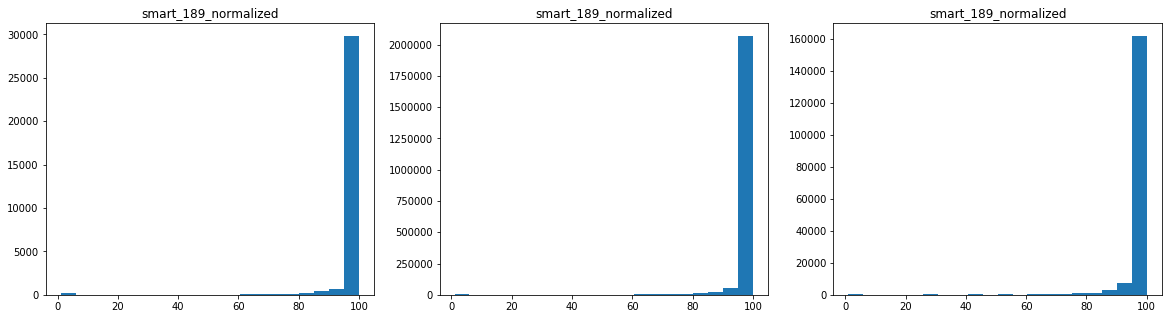

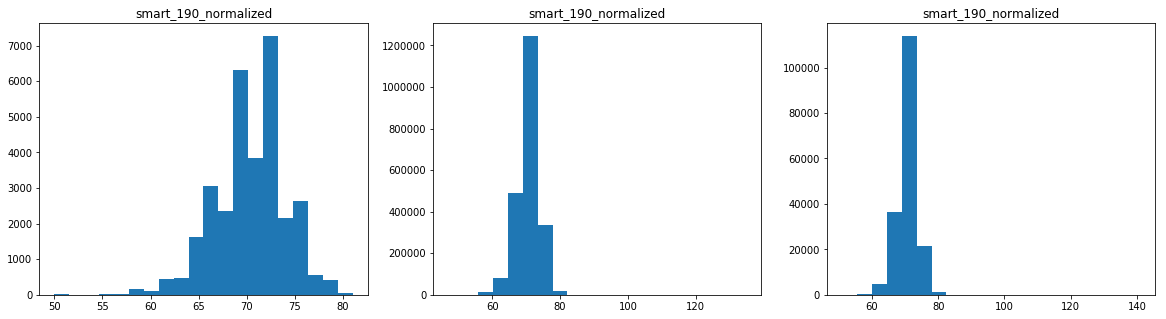

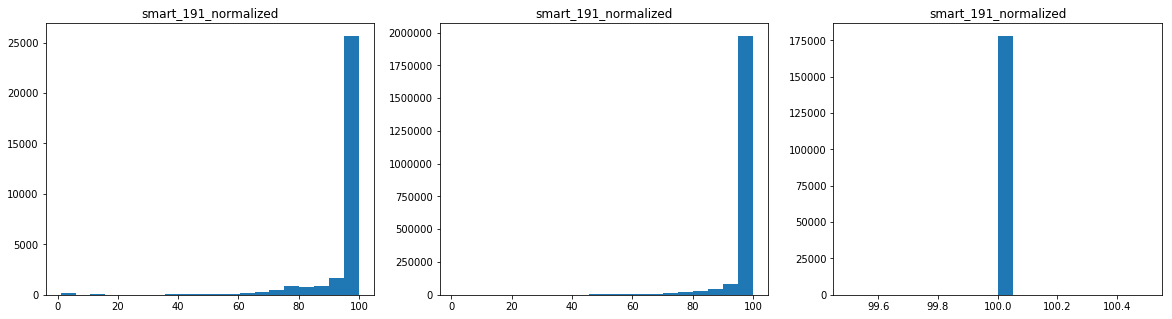

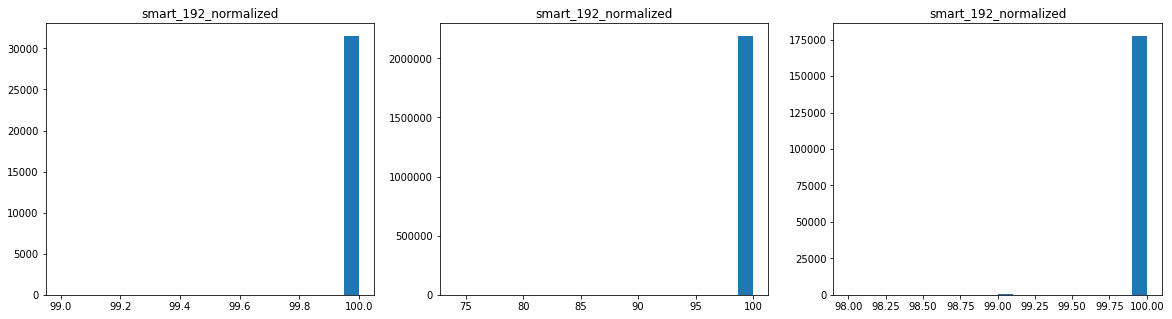

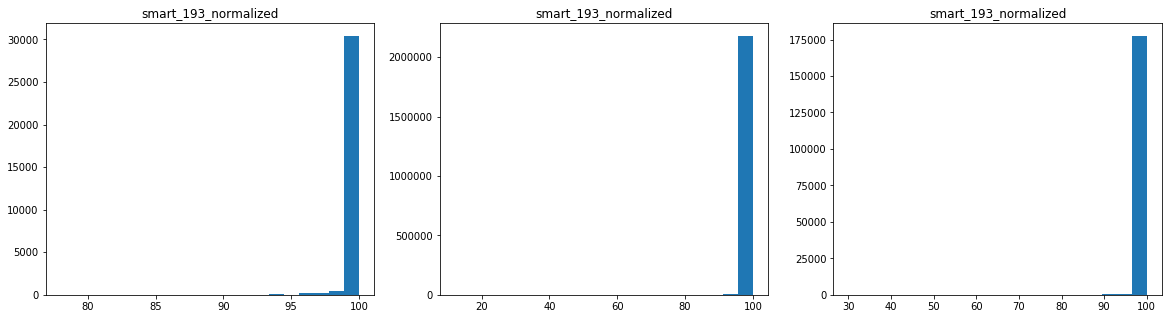

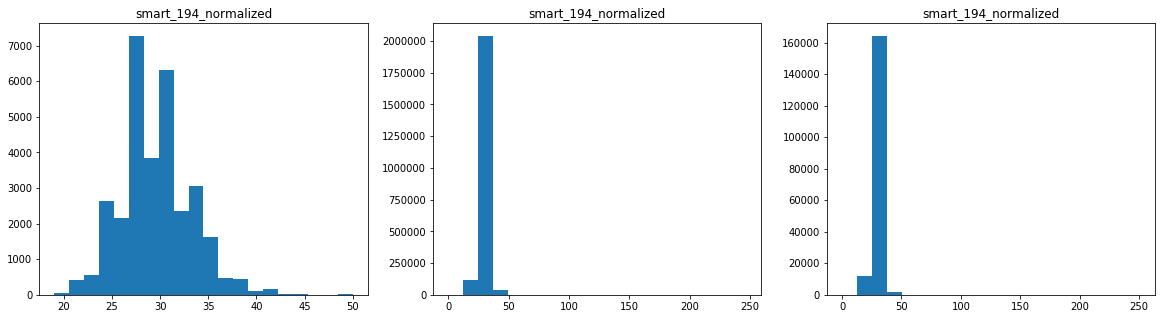

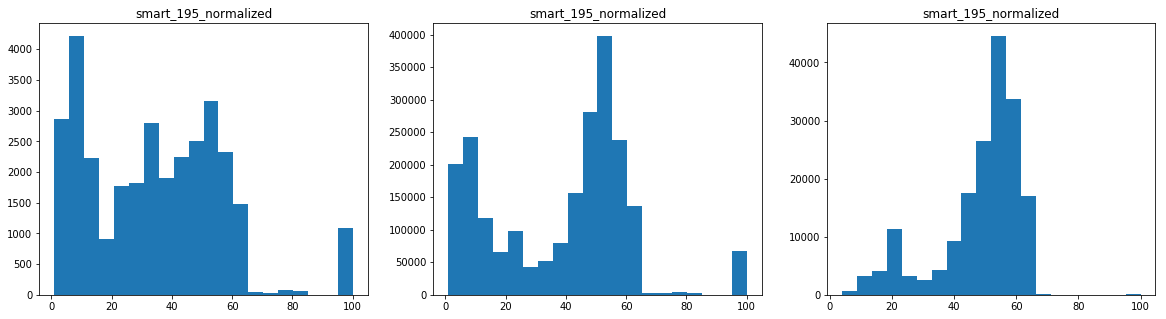

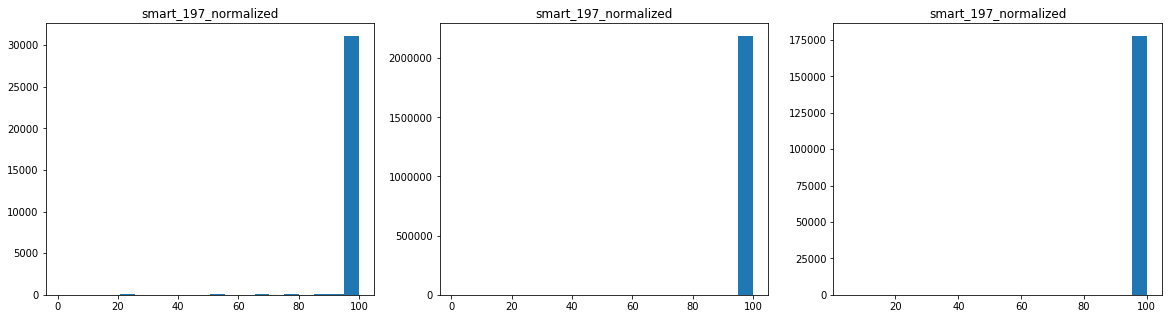

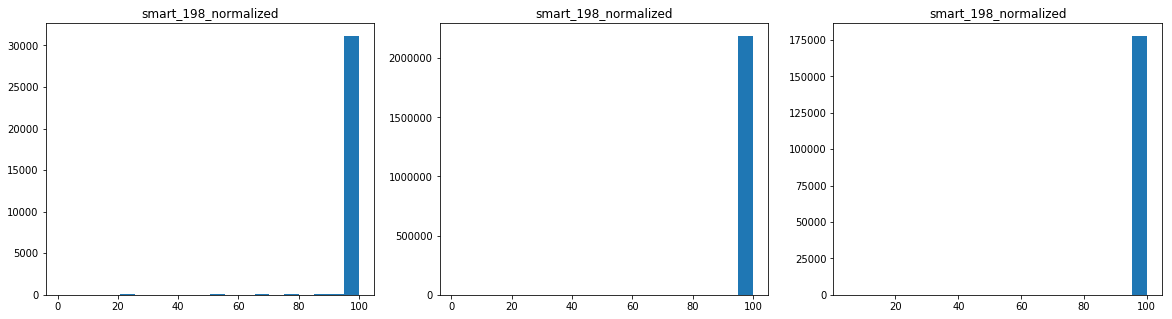

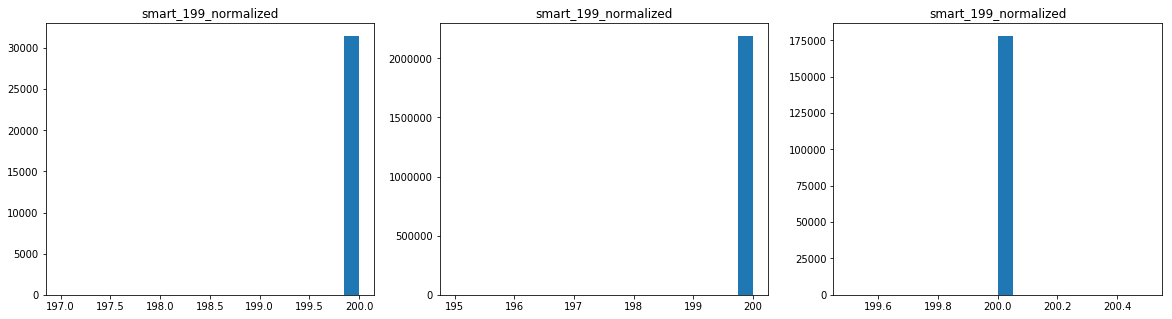

In [74]:
col_index = 0
for col_index in range(len(features)):
    plt.figure(figsize = (20, 5))
    
    plt.subplot(1, 3, 1) # row行，col列的大图上，绘制第i个图
    plt.hist(x = df_train[df_train['label'] == 1][features[col_index]].dropna().astype(np.float).tolist(), bins = 20)
    plt.title(features[col_index])
    
    plt.subplot(1, 3, 2) # row行，col列的大图上，绘制第i个图
    plt.hist(x = df_train[df_train['label'] == 0][features[col_index]].dropna().astype(np.float).tolist(), bins = 20)
    plt.title(features[col_index])
    
    plt.subplot(1, 3, 3) # row行，col列的大图上，绘制第i个图
    plt.hist(x = df_test[features[col_index]].dropna().astype(np.float).tolist(), bins = 20)
    plt.title(features[col_index])

plt.show()

In [75]:
black = df_train[df_train['label'] == 1]
white = df_train[df_train['label'] == 0]
for col in features:
    ratio1 = black[col].isna().sum() * 1.0 / len(black)
    ratio2 = white[col].isna().sum() * 1.0 / len(white)
    ratio3 = df_test[col].isna().sum() * 1.0 / len(df_test)
    print "%s, black is na : %.2f, white is na : %.2f, test is na : %.2f" % (col, ratio1 * 100, ratio2 * 100, ratio3 * 100)

smart_1_normalized, black is na : 0.01, white is na : 0.01, test is na : 0.00
smart_3_normalized, black is na : 0.01, white is na : 0.01, test is na : 0.00
smart_4_normalized, black is na : 0.01, white is na : 0.01, test is na : 0.00
smart_5_normalized, black is na : 0.01, white is na : 0.01, test is na : 0.00
smart_7_normalized, black is na : 0.01, white is na : 0.01, test is na : 0.00
smart_9_normalized, black is na : 0.01, white is na : 0.01, test is na : 0.00
smart_10_normalized, black is na : 0.01, white is na : 0.01, test is na : 0.00
smart_12_normalized, black is na : 0.01, white is na : 0.01, test is na : 0.00
smart_184_normalized, black is na : 0.01, white is na : 0.01, test is na : 0.00
smart_187_normalized, black is na : 0.00, white is na : 0.01, test is na : 0.00
smart_188_normalized, black is na : 0.00, white is na : 0.01, test is na : 0.00
smart_189_normalized, black is na : 0.00, white is na : 0.01, test is na : 0.00
smart_190_normalized, black is na : 0.00, white is na 